## IMPORTS

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import Counter
import gensim
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim_models
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS as stopwords_wordcloud
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.temporal_lda_model import TemporalLdaModel

## GLOBALS

In [48]:
corpus_path = ".\\UNGDC_1946-2023\\TXT"

In [49]:
# Lista com as pastas para cada ano de conferência

list_pastas = []
for root, dirs, files in os.walk(corpus_path):
    for dir in dirs:
        list_pastas.append(dir)

In [50]:
data = []

# Itera sobre cada pasta (ano de conferência)
for pasta in tqdm(list_pastas, desc = "Processando pastas"):
    pasta_path = os.path.join(corpus_path, pasta)
    
    # Itera sobre cada arquivo de texto na pasta
    for arq in os.listdir(pasta_path):
        # Ignora arquivos ocultos
        if not arq.startswith('.'):
            arq_path = os.path.join(pasta_path, arq)

            # Obtém ano e código do país do nome do arquivo
            ano = pasta.split(' - ')[1]
            codigo_pais = arq.split('_')[0]
            
            # Faz a leitura do conteúdo do arquivo
            with open(arq_path, 'r', encoding = 'utf-8') as f:
                discurso = f.read()
            
            # Adiciona o conteúdo do arquivo à lista de discursos
            data.append([ano, codigo_pais, discurso])

# Cria um dataframe da lista de discursos
df = pd.DataFrame(data, columns = ['ano', 'pais', 'texto'])

list_symbols = [
    '—', '–', '“', '”',
    '’', '‘', '…', ',',
    '.', '!', '?', ';',
    ':', '(', ')', '[',
    ']', '{', '}', '<',
    '>', '/', '\\', '|',
    '@', '#', '$', '%',
    '&', '*', '+', "'s",
    '"', '`', "''", '´',
]

# Remove símbolos da lista de símbolos
for symbol in list_symbols:
    df['texto'] = df['texto'].str.replace(symbol, '')


# df.to_csv('UNGDC_1946-2023.csv', index=False)

print(df)

Processando pastas: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]


        ano pais                                              texto
0      1946  ARG  At the resumption of the first session of the ...
1      1946  AUS  The General Assembly of the United Nations is ...
2      1946  BEL  The\tprincipal organs of the United Nations ha...
3      1946  BLR  As more than a year has elapsed since the Unit...
4      1946  BOL  Coming to this platform where so many distingu...
...     ...  ...                                                ...
10755  2023  WSM  Samoa extends its congratulations and best wis...
10756  2023  YEM  This session of the General Assembly is being ...
10757  2023  ZAF  Seventy-eight years ago in the aftermath of th...
10758  2023  ZMB  The world today is overcome with the overlappi...
10759  2023  ZWE  I wish to congratulate Mr Dennis Francis on hi...

[10760 rows x 3 columns]


##### REMOVER STOPWORDS

In [51]:
# Elabora um df geral dos discursos mas sem stopwords
stop_words = set(stopwords.words("english"))
df['texto_sem_stopwords'] = df['texto'].apply(
    lambda x: ' '.join([
        word for word in x.split()
        if word.lower() not in stop_words
    ])
)

##### LEMMATIZAÇÃO

In [52]:
# Baixa os recursos necessários do nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
lem = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lem.lemmatize(word) for word in words]

    valid_lem_words = []

    for word in lemmatized_words:
        if len(word) > 2:
            valid_lem_words.append(word)

    return ' '.join(valid_lem_words)

df['texto_lemmatized'] = df['texto_sem_stopwords'].apply(lemmatize_text)


##### SEPARAÇÃO DOS GRUPOS

In [54]:
# Faz a separação dos discursos dos países membros do G7
g7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
df_g7 = df[df['pais'].isin(g7)]

brics = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF']
df_brics = df[df['pais'].isin(brics)]

mercosul = [
    'ARG', 'BRA', 'PRY', 'URY'
]
df_mercosul = df[df['pais'].isin(mercosul)]

AU = [
    'ZAF', 'EGY', 'NGA', 'KEN', 'ETH', 'GHA', 'UGA', 'SEN', 'MOZ', 'TAN', 'CIV', 
    'ZMB', 'MLI', 'MWI', 'MWG', 'LSO', 'NAM', 'TGO'
]
df_au = df[df['pais'].isin(AU)]

NATO = [
    'USA', 'CAN', 'GBR', 'DEU', 'FRA', 'ITA', 'JPN', 'NLD', 'ESP', 'POL', 'TUR', 
    'DNK', 'BEL', 'CHE', 'NOR', 'PRT', 'HUN', 'ROU', 'BGR'
]
df_nato = df[df['pais'].isin(NATO)]

EU = [
    'AUT', 'SWE', 'FIN', 'IRL', 'GRC', 'CZE', 'SVK', 'SVN', 'LVA', 'LTU', 'BGR', 
    'CYP', 'EST', 'LUX', 'NLD', 'BEL', 'DEU', 'FRA', 'ITA', 'ESP', 'POL', 'HUN', 
    'ROU', 'SVK', 'GRC', 'POR'
]
df_eu = df[df['pais'].isin(EU)]

## VISÃO GERAL

### Histograma do número de caracteres por discurso

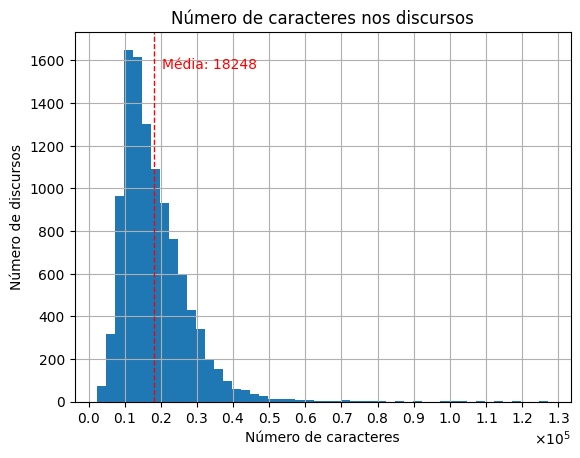

In [ ]:
df['n_caracteres_total'] = df['texto'].apply(lambda x: len(x))
df['n_caracteres_total'].hist(bins=50)
plt.xlabel("Número de caracteres")
plt.ylabel("Número de discursos")
plt.title("Número de caracteres nos discursos")

# Adiciona a linha da média
media_caracteres = int(df['n_caracteres_total'].mean())
plt.axvline(media_caracteres, color='r', linestyle = 'dashed', linewidth = 1)
plt.text(media_caracteres + 2000, plt.ylim()[1] * 0.9, f'Média: {media_caracteres}', color = 'r')

# Eixo x em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'x', scilimits = (0,0), useMathText = True)

# Número de ticks no eixo x
plt.locator_params(axis = 'x', nbins = 16)

plt.show()

### Histograma da quantidade de palavras por discurso

MAX: 22003
MIN: 423


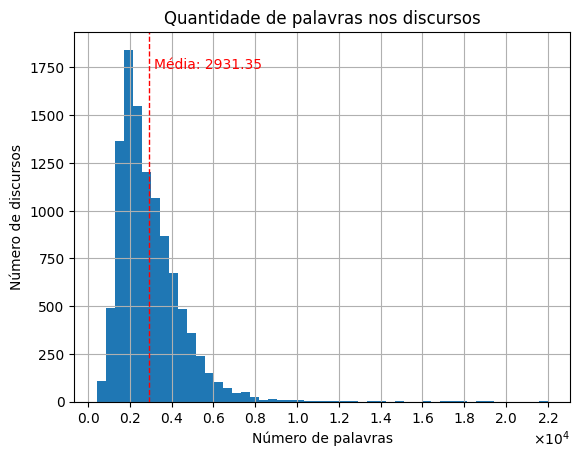

In [ ]:
df['n_palavras'] = df['texto'].apply(lambda x: len(x.split()))
df['n_palavras'].hist(bins = 50)
plt.xlabel("Número de palavras")
plt.ylabel("Número de discursos")
plt.title("Quantidade de palavras nos discursos")

# Discurso com mais palavras
print(f"MAX: {df['n_palavras'].max()}")

# Discurso com menos palavras
print(f"MIN: {df['n_palavras'].min()}")

# Adiciona a linha da média
media_palavras = df['n_palavras'].mean()
plt.axvline(media_palavras, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_palavras + 200, plt.ylim()[1] * 0.9, f'Média: {media_palavras:.2f}', color = 'r')

# Eixo x em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'x', scilimits = (0,0), useMathText = True)

# Mais ticks no eixo x
plt.locator_params(axis = 'x', nbins = 16)

plt.show()

### Histograma do tamanho médio das palavras por discurso

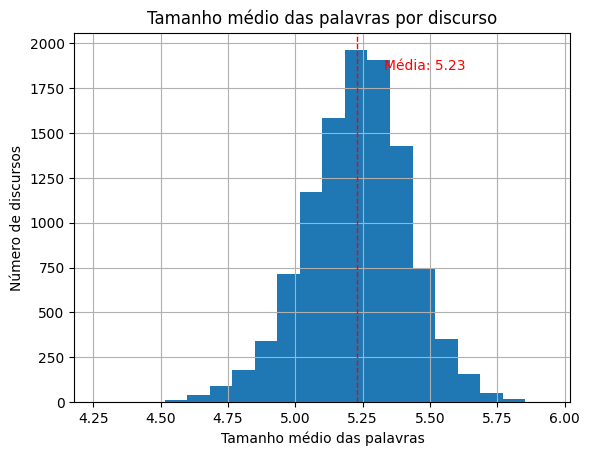

In [ ]:
df['tamanho_palavras'] = df['texto'].apply(lambda x: sum(len(p) for p in x.split()) / len(x.split()))
df['tamanho_palavras'].hist(bins = 20)
plt.xlabel("Tamanho médio das palavras")
plt.ylabel("Número de discursos")
plt.title("Tamanho médio das palavras por discurso")

# Adiciona uma linha indicando a média do tamanho das palavras por discurso
media_tamanho_palavras = df['tamanho_palavras'].mean()
plt.axvline(media_tamanho_palavras, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_tamanho_palavras + 0.1, plt.ylim()[1] * 0.9, f'Média: {media_tamanho_palavras:.2f}', color = 'r')

plt.show()

### Histograma da quantidade de palavras por tamanho de palavra

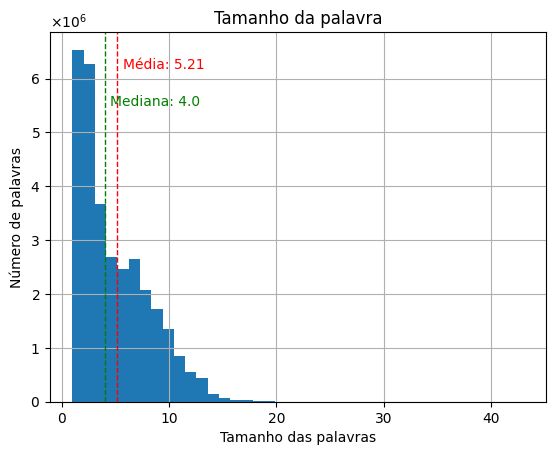

In [ ]:
tamanho_palavras = df['texto'].str.split().explode().str.len()
tamanho_palavras.hist(bins = 40)
plt.xlabel("Tamanho das palavras")
plt.ylabel("Número de palavras")
plt.title("Tamanho da palavra")

media_tamanho = tamanho_palavras.mean()
mediana_tamanho = tamanho_palavras.median()
# Linha da média
plt.axvline(media_tamanho, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_tamanho + 0.5, plt.ylim()[1] * 0.9, f"Média: {media_tamanho:.2f}", color='r')

# Linha da mediana
plt.axvline(mediana_tamanho, color='g', linestyle='dashed', linewidth=1)
plt.text(mediana_tamanho + 0.5, plt.ylim()[1] * 0.8, f"Mediana: {mediana_tamanho}", color='g')

# Eixo y em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0,0), useMathText = True)

plt.show()

### Histograma com a contagem de stopwords em inglês

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ander\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


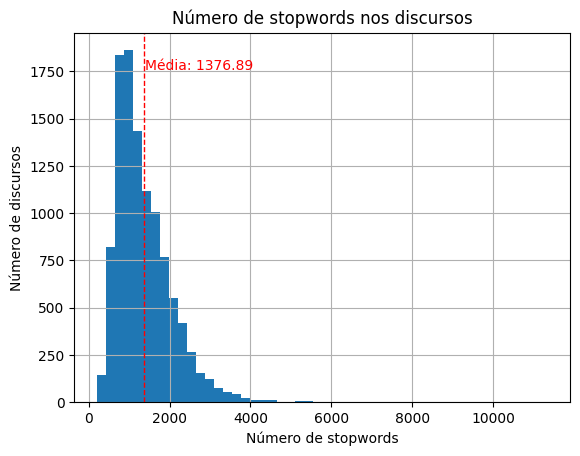

In [ ]:
# Utiliza a biblioteca nltk para obter a lista de stopwords em inglês
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df['n_stopwords'] = df['texto'].apply(lambda x: len([p for p in x.split() if p.lower() in stop_words]))
df['n_stopwords'].hist(bins=50)
plt.xlabel("Número de stopwords")
plt.ylabel("Número de discursos")
plt.title("Número de stopwords nos discursos")

# Adiciona a linha da média
media_stopwords = df['n_stopwords'].mean()
plt.axvline(media_stopwords, color = 'r', linestyle = 'dashed', linewidth = 1)
plt.text(media_stopwords + 10, plt.ylim()[1] * 0.9, f"Média: {media_stopwords:.2f}", color='r')

plt.show()


### Gráfico de barras da frequência das 15 stopwords mais comuns

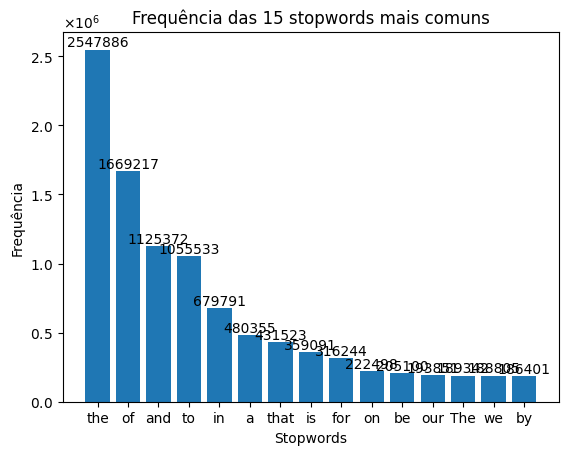

In [ ]:
stopwords_freq = Counter([p for p in ' '.join(df['texto']).split() if p.lower() in stop_words])
stopwords_freq = stopwords_freq.most_common(15)

plt.bar([p[0] for p in stopwords_freq], [p[1] for p in stopwords_freq])
plt.xlabel("Stopwords")
plt.ylabel("Frequência")
plt.title("Frequência das 15 stopwords mais comuns")

# Adiciona os valores no topo das barras
for i, freq in enumerate(stopwords_freq):
    plt.text(i, freq[1], freq[1], ha='center', va='bottom')

# Eixo y em notação científica
plt.ticklabel_format(style = 'scientific', axis = 'y', scilimits = (0,0), useMathText = True)

plt.show()

### Gráfico de barras da frequência das 15 palavras mais comuns

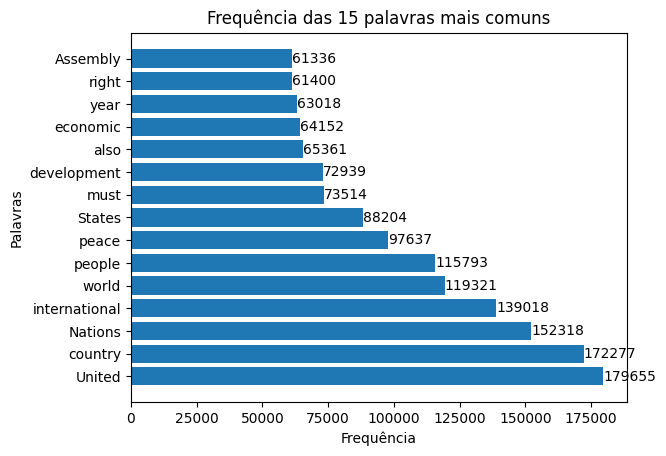

In [61]:
palavras_freq = Counter([p for p in ' '.join(df['texto_lemmatized']).split() if p.lower() not in stop_words])
palavras_freq_mais_comum = palavras_freq.most_common(15)

plt.barh([p[0] for p in palavras_freq_mais_comum], [p[1] for p in palavras_freq_mais_comum])
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.title("Frequência das 15 palavras mais comuns")

# Adiciona os valores no final das barras
for i, freq in enumerate(palavras_freq_mais_comum):
    plt.text(freq[1], i, freq[1], ha = 'left', va = 'center')

plt.show()

### Gráfico de barras da frequência das 15 palavras mais comuns excluindo algumas específicas

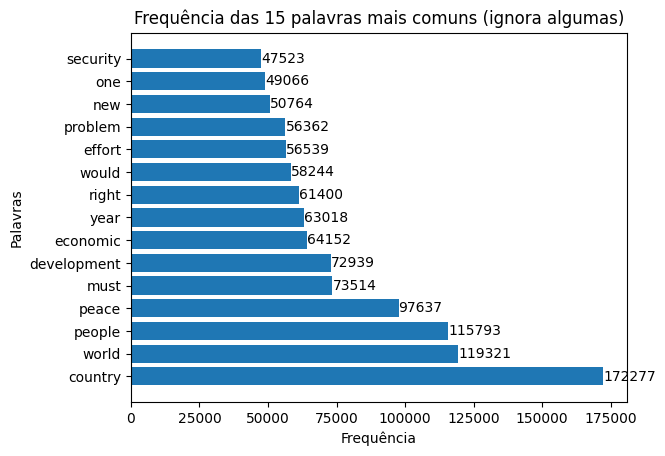

In [60]:
palavras_nao_incluir = [
    'United',
    'Nations',
    'States',
    'Government',
    'international',
    'countries',
    'us',
    'also',
    'Assembly',
    'General',
    '—'
]

palavras_freq_exc_algumas = Counter([p for p in ' '.join(df['texto_lemmatized']).split() if p.lower() not in stop_words and p not in palavras_nao_incluir])
palavras_freq_mais_comum_exc_algumas = palavras_freq_exc_algumas.most_common(15)

plt.barh([p[0] for p in palavras_freq_mais_comum_exc_algumas], [p[1] for p in palavras_freq_mais_comum_exc_algumas])
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.title("Frequência das 15 palavras mais comuns (ignora algumas)")

# Adiciona os valores no final das barras
for i, freq in enumerate(palavras_freq_mais_comum_exc_algumas):
    plt.text(freq[1], i, freq[1], ha = 'left', va = 'center')

plt.show()

### Gráfico de barras do número de discursos por país

#### G7

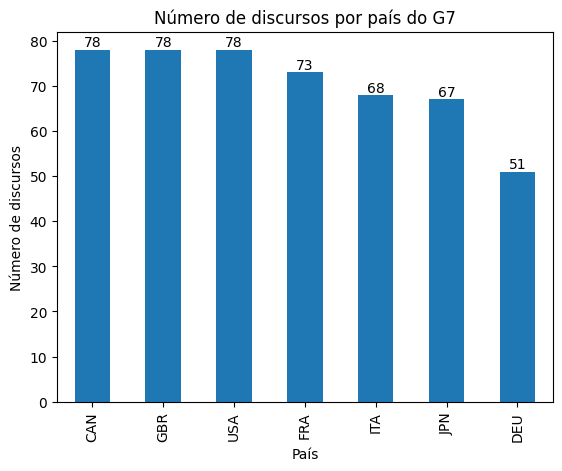

In [ ]:
sigla_paises_g7 = ['USA', 'GBR', 'FRA', 'DEU', 'ITA', 'CAN', 'JPN']

df_g7 = df[df['pais'].isin(sigla_paises_g7)]
df_g7['pais'].value_counts().plot(kind = 'bar')
plt.title("Número de discursos por país do G7")

plt.xlabel("País")
plt.ylabel("Número de discursos")

for i, freq in enumerate(df_g7['pais'].value_counts()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

#### BRICS

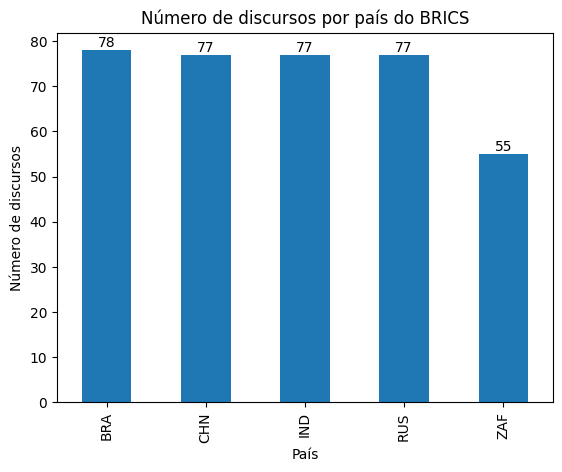

In [ ]:
sigla_paises_brics = ['BRA', 'RUS', 'IND', 'CHN', 'ZAF']

df_brics = df[df['pais'].isin(sigla_paises_brics)]
df_brics['pais'].value_counts().plot(kind = 'bar')

plt.title("Número de discursos por país do BRICS")
plt.xlabel("País")
plt.ylabel("Número de discursos")

for i, freq in enumerate(df_brics['pais'].value_counts()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

### Gráfico de barras do número de discursos por ano

#### Período da guerra fria (1946 - 1991)

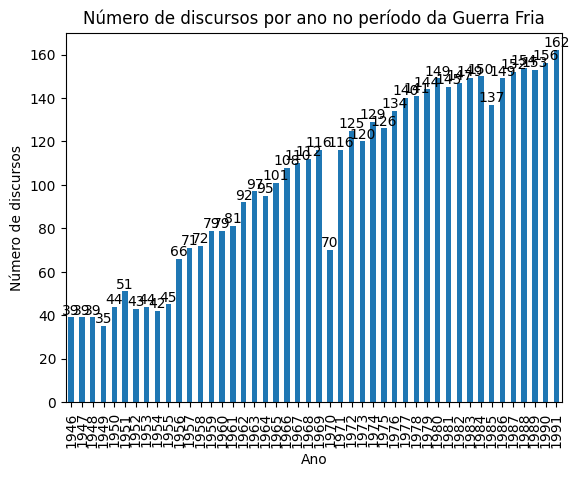

In [ ]:
df_guerra_fria = df[df['ano'].between('1946', '1991')]
df_guerra_fria['ano'].value_counts().sort_index().plot(kind = 'bar')
plt.title("Número de discursos por ano no período da Guerra Fria")
plt.xlabel("Ano")
plt.ylabel("Número de discursos")

for i, freq in enumerate(df_guerra_fria['ano'].value_counts().sort_index()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

#### Período pós-Guerra Fria (1992 - 2023)

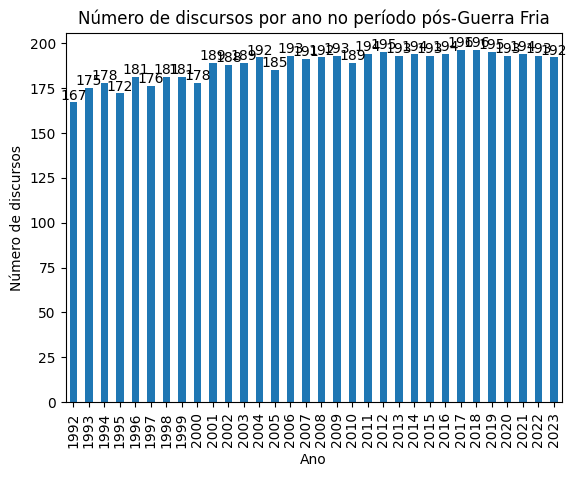

In [ ]:
df_pos_guerra_fria = df[df['ano'].between('1992', '2023')]
df_pos_guerra_fria['ano'].value_counts().sort_index().plot(kind = 'bar')

plt.title("Número de discursos por ano no período pós-Guerra Fria")
plt.xlabel("Ano")
plt.ylabel("Número de discursos")

# Adiciona os valores no topo das barras
for i, freq in enumerate(df_pos_guerra_fria['ano'].value_counts().sort_index()):
    plt.text(i, freq, freq, ha = 'center', va = 'bottom')

plt.show()

## ANÁLISE EXPLORATÓRIA

### EXPLORAÇÃO NGRAM COM STOPWORDS

In [ ]:
def get_top_ngram(corpus, n_top = 10, n = None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [
        (word, sum_words[0, idx])
        for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n_top]

#### GERAL

##### 2GRAM

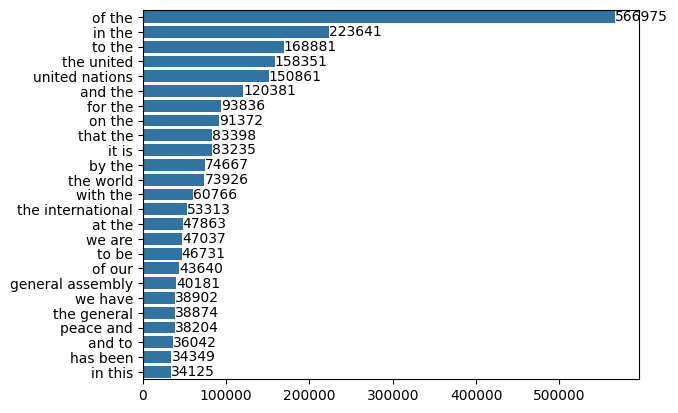

In [ ]:
top_n_bigrams = get_top_ngram(df['texto'], 25, 2)
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

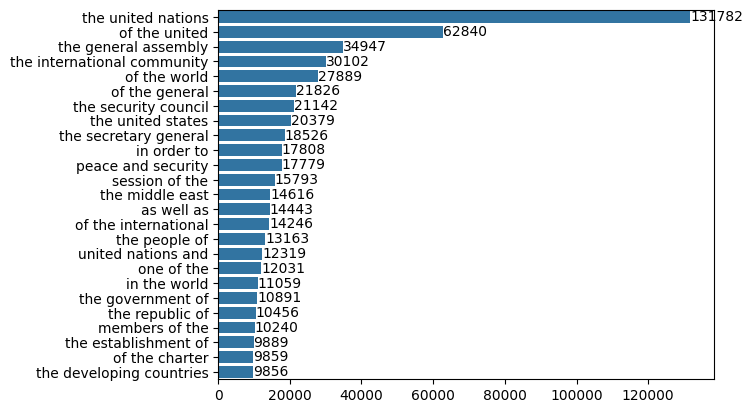

In [ ]:
top_n_trigrams = get_top_ngram(df['texto'], 25, 3)
x,y=map(list,zip(*top_n_trigrams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

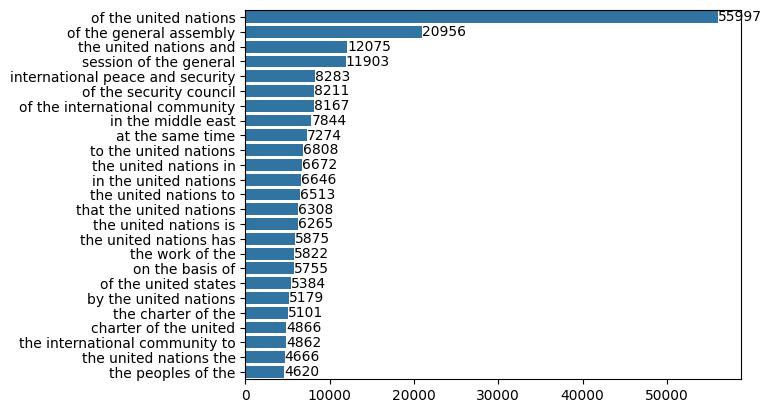

In [ ]:
top_n_5grams = get_top_ngram(df['texto'], 25, 4)
x,y=map(list,zip(*top_n_5grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

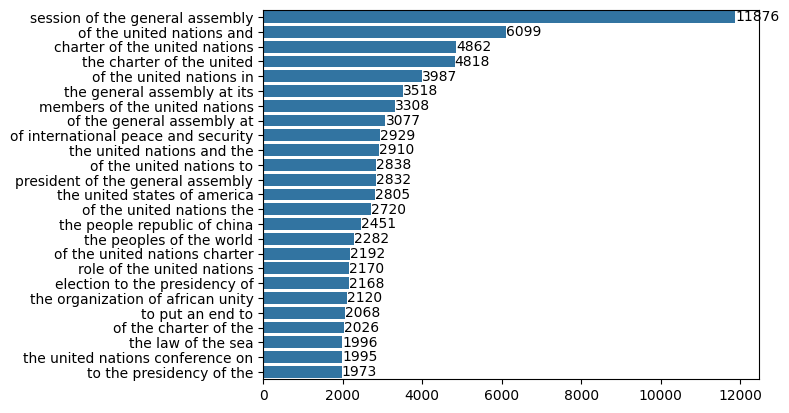

In [ ]:
top_n_5grams = get_top_ngram(df['texto'], 25, 5)
x,y=map(list,zip(*top_n_5grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

#### G7

##### 2GRAM

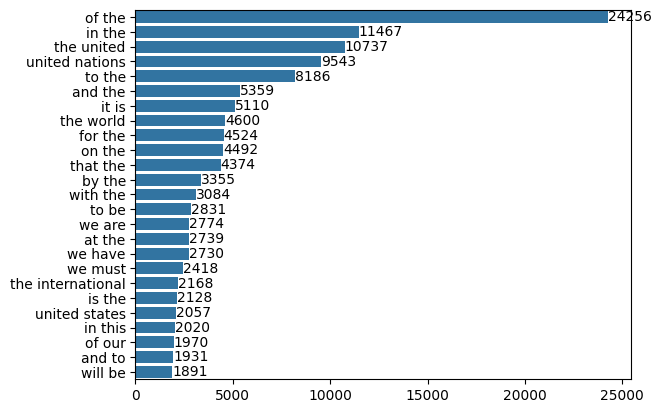

In [ ]:
# Obem os 25 bigramas mais comuns para os países do G7
top_n_bigrams_g7 = get_top_ngram(df_g7['texto'], 25, 2)
x,y=map(list,zip(*top_n_bigrams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

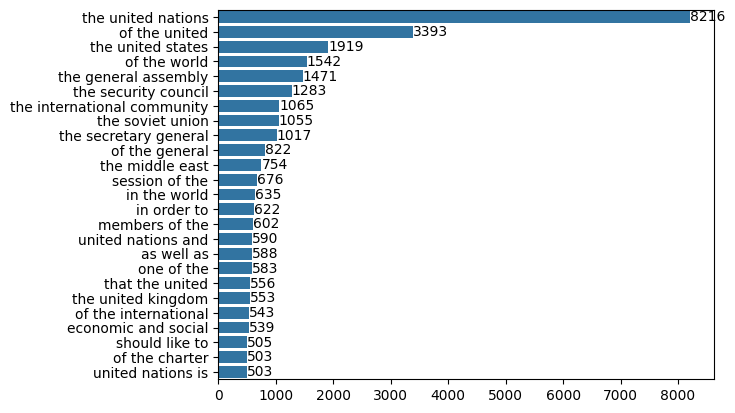

In [ ]:
# Obtem os 25 trigramas mais comuns para os países do G7
top_n_trigrams_g7 = get_top_ngram(df_g7['texto'], 25, 3)
x,y=map(list,zip(*top_n_trigrams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

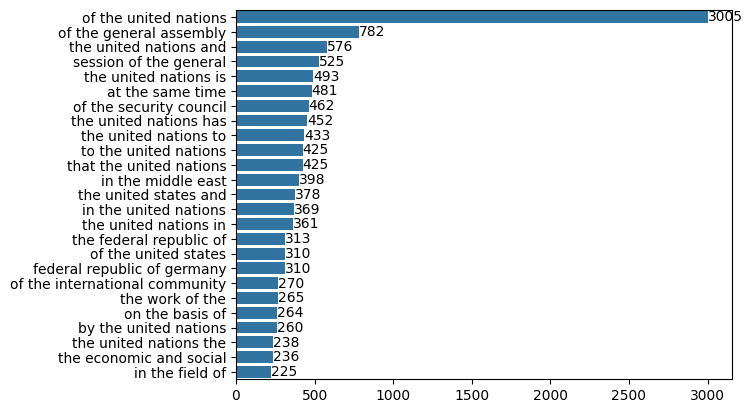

In [ ]:
# Obtem os 25 quadrigramas mais comuns para os países do G7
top_n_quadrigrams_g7 = get_top_ngram(df_g7['texto'], 25, 4)
x,y=map(list,zip(*top_n_quadrigrams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

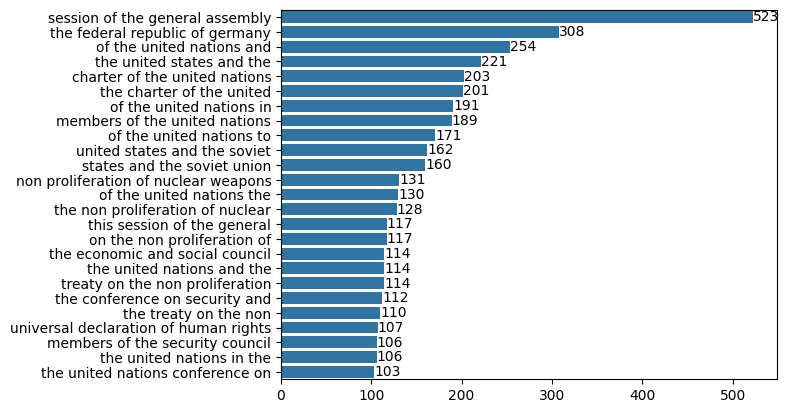

In [ ]:
# Os 25 5gramas mais comuns para os países do G7
top_n_5grams_g7 = get_top_ngram(df_g7['texto'], 25, 5)
x,y=map(list,zip(*top_n_5grams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')


#### BRICS

##### 2GRAM

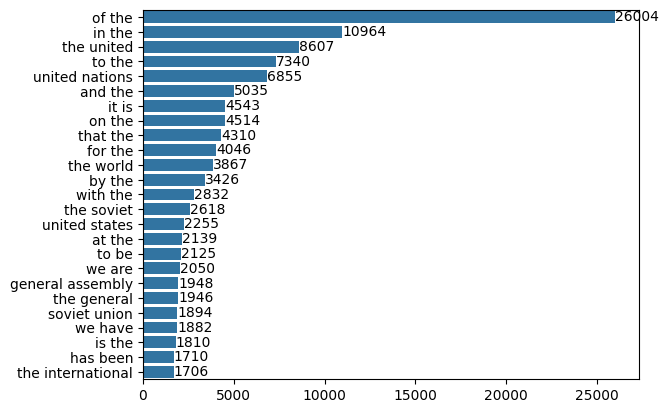

In [ ]:
# Obtem os 25 bigramas mais comuns para os países do BRICS
top_n_2grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_2grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

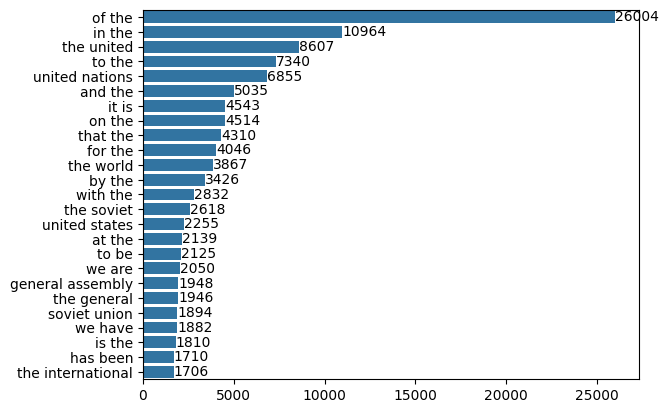

In [ ]:
top_n_3grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_3grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

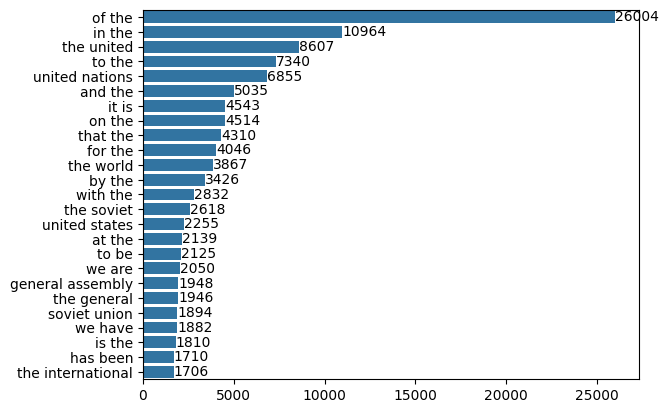

In [ ]:
top_n_4grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_4grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

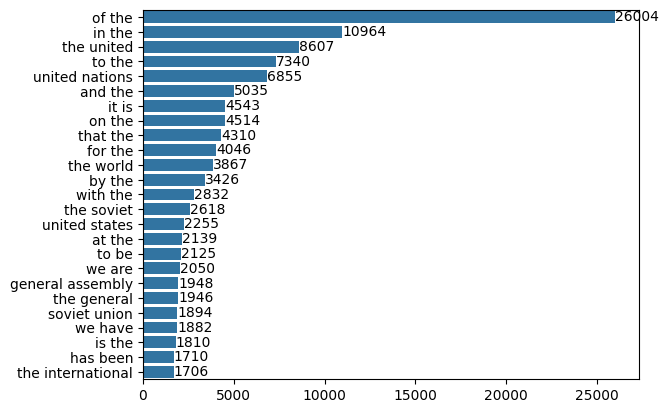

In [ ]:
top_n_5grams_brics = get_top_ngram(df_brics['texto'], 25, 2)
x,y=map(list,zip(*top_n_5grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

### EXPLORAÇÃO NGRAM SEM STOPWORDS

#### GERAL

##### 2GRAM

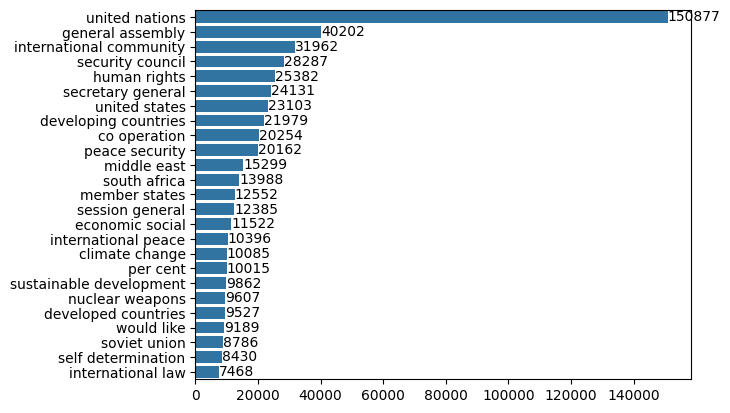

In [ ]:
# Obtem os 25 2gramas mais comuns do geral sem stopwords
top_n_2grams = get_top_ngram(df['texto_sem_stopwords'], 25, 2)
x,y=map(list,zip(*top_n_2grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

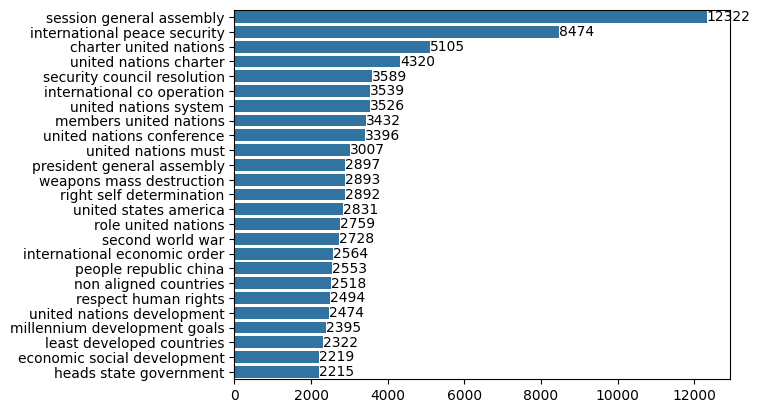

In [ ]:
# Obtem os 25 3gramas mais comuns do geral sem stopwords
top_n_3grams = get_top_ngram(df['texto_sem_stopwords'], 25, 3)
x,y=map(list,zip(*top_n_3grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

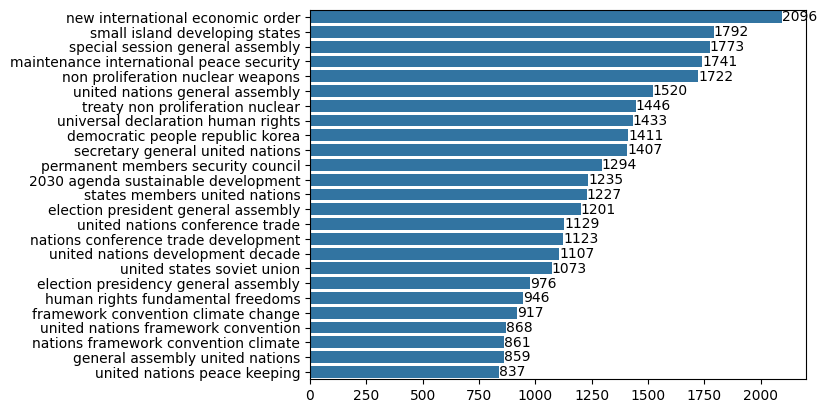

In [ ]:
# Obtem os 25 4gramas mais comuns do geral sem stopwords
top_n_4grams = get_top_ngram(df['texto_sem_stopwords'], 25, 4)
x,y=map(list,zip(*top_n_4grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

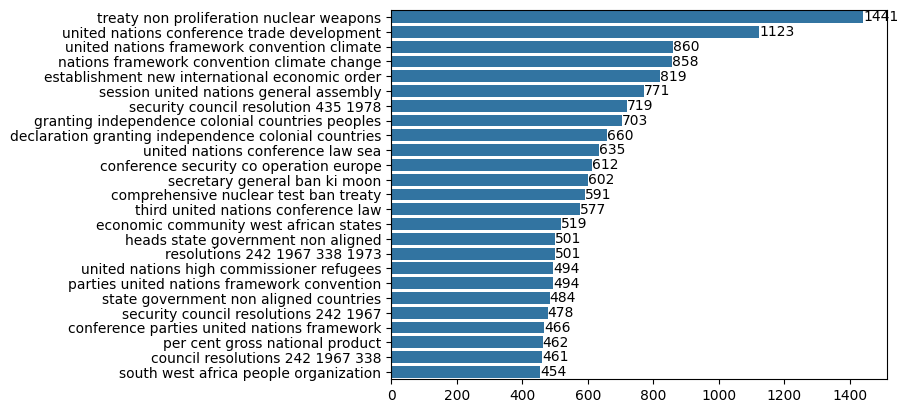

In [ ]:
# Obtem os 25 5gramas mais comuns do geral sem stopwords
top_n_5grams = get_top_ngram(df['texto_sem_stopwords'], 25, 5)
x,y=map(list,zip(*top_n_5grams))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

#### G7

##### 2GRAM

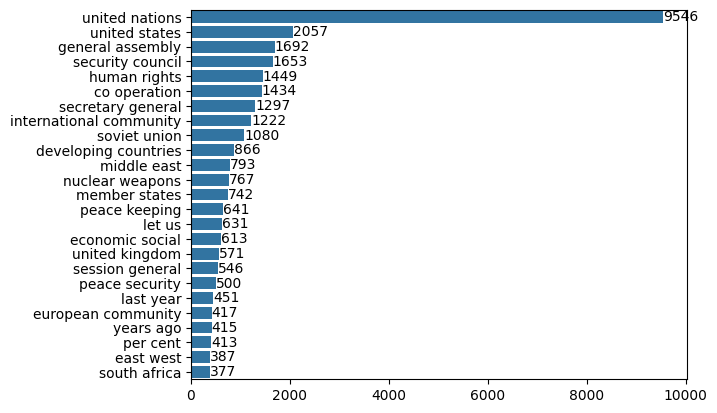

In [ ]:
# Obtem os 25 2gramas mais comuns para os países do G7 sem stopwords
top_n_2grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 2)
x,y=map(list,zip(*top_n_2grams_g7))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

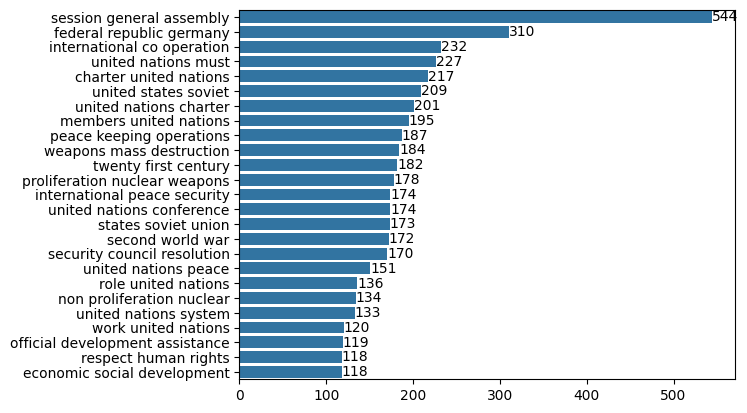

In [ ]:
# Obtem os 25 3gramas mais comuns para os países do G7 sem stopwords
top_n_3grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 3)
x,y=map(list,zip(*top_n_3grams_g7))
sns.barplot(x=y,y=x)    

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

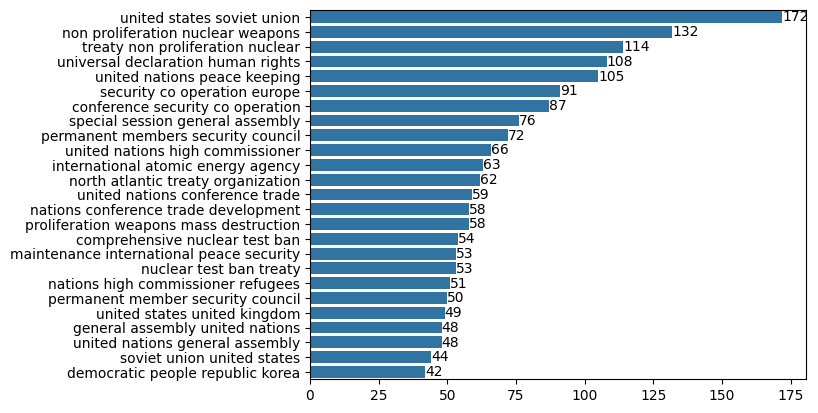

In [ ]:
# Obtem os 25 4gramas mais comuns para os países do G7 sem stopwords
top_n_4grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 4)
x,y=map(list,zip(*top_n_4grams_g7))
sns.barplot(x=y,y=x)    

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

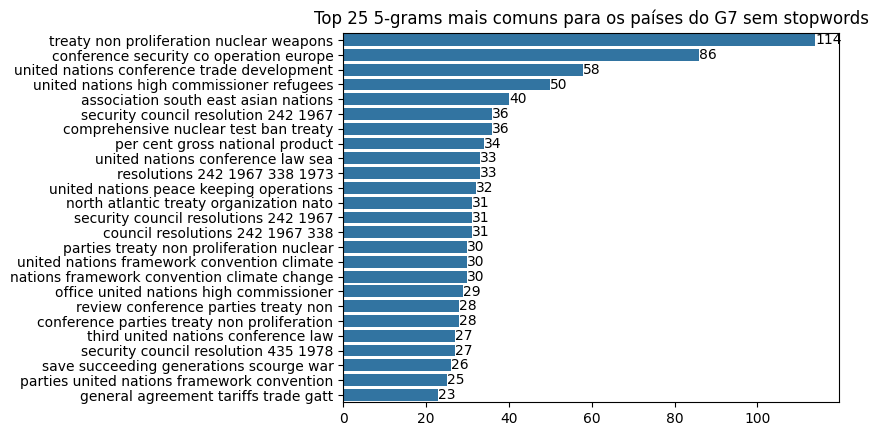

In [ ]:
# Obtem os 25 5gramas mais comuns para os países do G7 sem stopwords
top_n_5grams_g7 = get_top_ngram(df_g7['texto_sem_stopwords'], 25, 5)
x,y=map(list,zip(*top_n_5grams_g7))
plt.title("Top 25 5-grams mais comuns para os países do G7 sem stopwords")
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

#### BRICS

##### 2GRAM

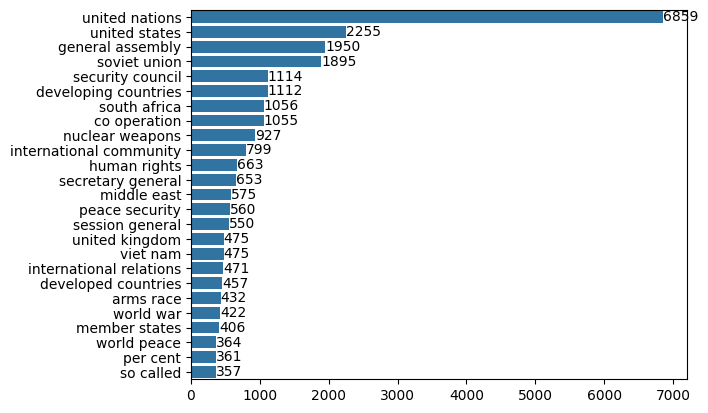

In [ ]:
# Obtem os 25 2gramas mais comuns para os países do BRICS sem stopwords
top_n_2grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 2)
x,y=map(list,zip(*top_n_2grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 3GRAM

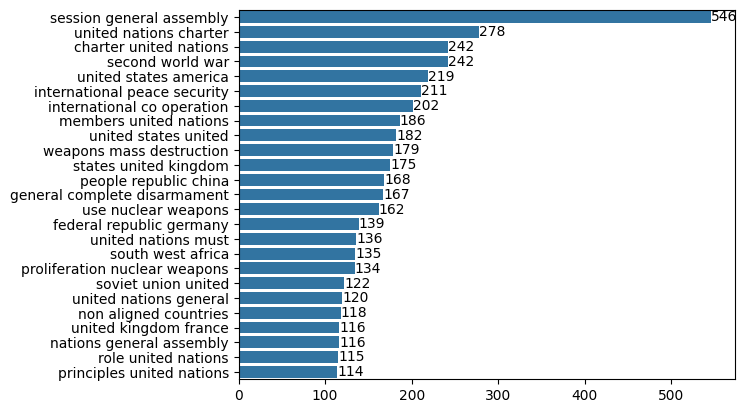

In [ ]:
# Obtem os 25 3gramas mais comuns para os países do BRICS sem stopwords
top_n_3grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 3)
x,y=map(list,zip(*top_n_3grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 4GRAM

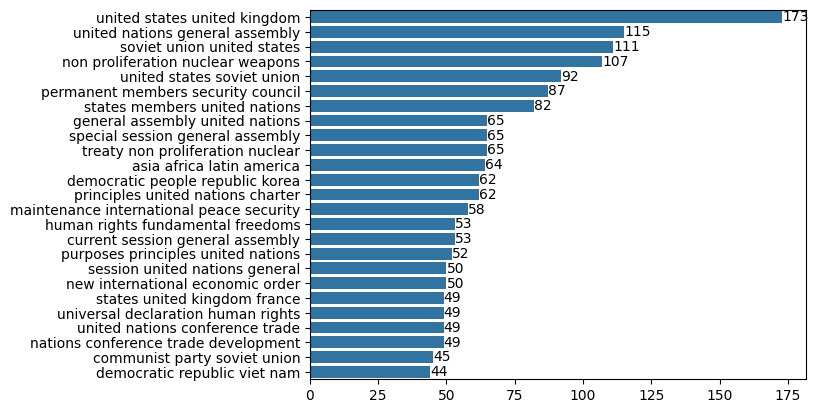

In [ ]:
# Obtem os 25 4gramas mais comuns para os países do BRICS sem stopwords
top_n_4grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 4)
x,y=map(list,zip(*top_n_4grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')

##### 5GRAM

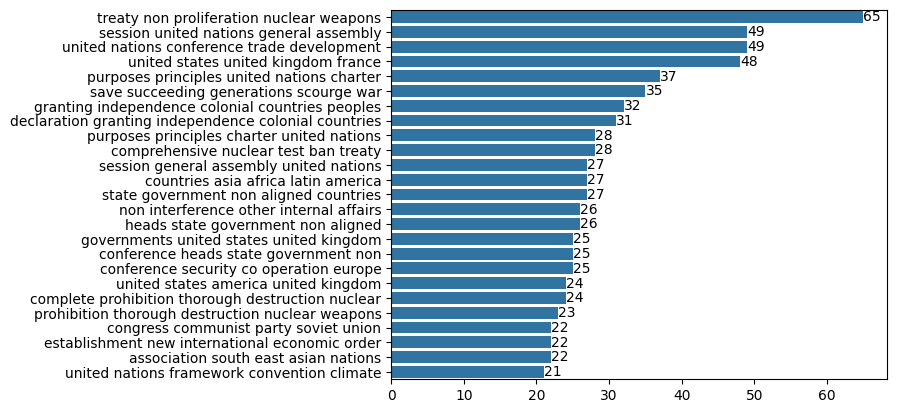

In [ ]:
# Obtem os 25 5gramas mais comuns para os países do BRICS sem stopwords
top_n_5grams_brics = get_top_ngram(df_brics['texto_sem_stopwords'], 25, 5)
x,y=map(list,zip(*top_n_5grams_brics))
sns.barplot(x=y,y=x)

for i, freq in enumerate(y):
    plt.text(freq, i, freq, ha = 'left', va = 'center')